# Detecting Heart Arrhythmias with Deep Learning in Keras CNN

Here is a machine learning algorithm that could detect abnormal heart beats.
In this project we have used a data which is collected through IoT devices and trained 3 neural 
networks to predict heart arrhythmias i.e dense neural network, CNN, and LSTM.But We found greater accuracy rate
on CNN so we have presented the CNN model.

### Our project basically consits of main 3 section 
<ol>
<li>
Data Preparation</li>
<li>
Make a dataset</li>
<li>
Create and train deep neural network</li>
</ol>

### Dataset
We have used the MIH-BIH Arrythmia dataset which is made aavailable under the ODC Attribution License.
This data set is bacically 48 hours of heartbeat reacodings measured at 360 Hz ie 360 data points per second.
The recordings have a pulse singnal value and annotations from cardiologist for each heart beat.The diffrent symbols 
have diffrent meanings for example
<ul>
<li>
N --> Normal beat 
<li>
L --> Left bundle branch block beat</li>
<li>
R --> Right bundle branch block beat</li>
<li>
B --> Bundle branch block beat (unspecified)</li>
<li>
A --> Atrial premature beat</li>
<li>
[ --> Start of ventricular flutter/fibrillation</li>
<li>
! --> Ventricular flutter wave</li>
 <li>
] --> End of ventricular flutter/fibrillation</li>
<li>
x --> Non-conducted P-wave (blocked APC)</li>
</ul>

### Our project
We have made our model to predict heart beat annotations from pulse signal for each 6 second window centered on
the peak of the heart beat. We have used 6 seconds window so that we can compare the current beat to beats which 
just before and after. This decision was based after talking to a physician who said it is easier to identify 
if you have something to compare it to.

## (i) Data Preparation

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

In [18]:
# dataset importing
data_path = 'mit-bih-arrhythmia-database-1.0.0/'

In [19]:
# list of patients (48)
pts = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210',
       '212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

Here we have used package wfdb for loading the patients record and annotations.

In [20]:
import wfdb

Here we have loaded all the annotations and displyed the distribution of heart beat types across all files.

In [21]:
df = pd.DataFrame()

for pt in pts:
    file = data_path + pt
    annotation = wfdb.rdann(file, 'atr')
    sym = annotation.symbol
    
    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({'sym':values, 'val':counts, 'pt':[pt]*len(counts)})
    df = pd.concat([df, df_sub],axis = 0)

In [22]:
df.groupby('sym').val.sum().sort_values(ascending = False)

sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

Here we have divided the list of symbols into 3 categories

In [25]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [26]:
#break into normal, abnormal or nonbeat
df['cat'] = -1
df.loc[df.sym == 'N','cat'] = 0
df.loc[df.sym.isin(abnormal), 'cat'] = 1

In [27]:
df.groupby('cat').val.sum()

cat
-1     3186
 0    75052
 1    34409
Name: val, dtype: int64

We can see that 30% in this dataset are abnormal

Then we wrote some functions for loading a single patient's singnals and annotations.(30min of data)

In [33]:
def load_ecg(file):
    # load the ecg
    # example file: 'mit-bih-arrhythmia-database-1.0.0/101'
    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extract the signal
    p_signal = record.p_signal
    
    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample

In [35]:
file = data_path + pts[0]

In [36]:
p_signal, atr_sym, atr_sample = load_ecg(file)

We have displyed the abnormal beats are in a patient’s record

In [37]:
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


Here we are ploting the signal around one of the abnormal beats

In [38]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

In [39]:
x = np.arange(len(p_signal))

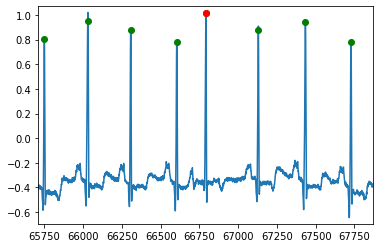

In [40]:
left = ab_index[1]-1080
right = ab_index[1]+1080

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')
plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.show()

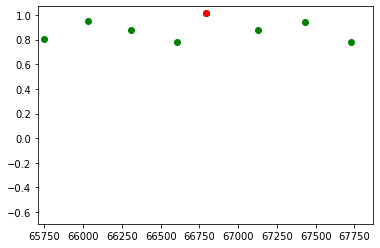

In [56]:
left = ab_index[1]-1080
right = ab_index[1]+1080

#plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')
plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.show()

## (ii) Make a dataset

We are made a dataset that is centered on beats with +- 3 seconds before and after

In [45]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data_path + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]
    
    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'
    return X_all, Y_all, sym_all
def build_XY(p_signal, df_ann, num_cols, abnormal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)
    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0
    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):
        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym

In [46]:
num_sec = 3
fs = 360
X_all, Y_all, sym_all = make_dataset(pts, num_sec, fs, abnormal)

Here we are splitting data into train and validate datasets

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_all, Y_all, test_size=0.33, random_state=42)

## CNN

Here we have made our CNN. Here we have used a 1 dimensional CNN (as opposed to the 2D CNN for images).
A CNN is a special type of deep learning algorithm which uses a set of filters and the convolution operator 
to reduce the number of parameters.Essentially, the way this works for 1D CNN is to take a filter (kernel) of 
size kernel_size starting with the first time stamp. The convolution operator takes the filter and multiplies 
each element against the first 
kernel_size time steps. These products are then summed for the first cell in the next layer of the neural network. 
The filter then moves over by stride time steps and repeats. The output of the convolution is then 
multiplied by a set of weights W and added to a bias b and then passed through a non-linear activation function.
Here we have used Dropout 
which is a technique for reducing overfitting by randomly removing some nodes.

For Keras’ CNN model, we need to reshape our data just a bit

In [48]:
# reshape input to be [samples, time steps, features = 1]
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

print(X_train_cnn.shape)
print(X_valid_cnn.shape)

(73096, 2160, 1)
(36003, 2160, 1)


Here we have used a one layer CNN with drop out

In [49]:
from keras.layers import Conv1D

In [50]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical

In [51]:
model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu', input_shape = (2160,1)))
model.add(Dropout(rate = 0.25))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [30]:
model.fit(X_train_cnn, y_train, batch_size = 32, epochs= 2, verbose = 1)

Epoch 1/2
2285/2285 [==============================] - 397s 173ms/step - loss: 0.2937 - accuracy: 0.8878
Epoch 2/2
2285/2285 [==============================] - 380s 166ms/step - loss: 0.1344 - accuracy: 0.9595


In [56]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model.load_weights("model.h5")

### Validating the model

Here we are making predictions from our trained Keras model with predict method on test dataset

In [61]:
y_valid_preds_cnn = model.predict(X_valid_cnn,verbose = 1)

1126/1126 [==============================] - 44s 33ms/step


Here we have wrote some functions for metrics reporting

In [64]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    ##print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    ##print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    ##print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    ##return auc, accuracy, recall, precision, specificity

thresh = (sum(y_train)/len(y_train))[0]

In [65]:
print('Valid');
print_report(y_valid, y_valid_preds_cnn, thresh)

Valid
accuracy:0.963
precision:0.932
specificity:0.968
 
